In [127]:
#################################################################
#Developed by Jonathan Ojeda 20-01-2021 QAAFI-UQ
#Functionality:
#Convert from date to julian day
#Get soybean planting dates by US state using data from NASS-USDA
#Convert dtypes
#Locate specific rows and make a new dataframe
#create new rows with data
#Create campaig file for planting date
#Use of pivot table to trnspose data
#################################################################

In [9]:
import os
import sqlite3
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import dateutil
import pylab as py
import seaborn as sns
import scipy 
from scipy import stats
import sklearn.metrics
from numpy  import array
import glob
import functools
from functools import reduce
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition, mark_inset)
import statsmodels.api as sm
import matplotlib.patheffects as path_effects
import matplotlib.lines as mlines
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

## Arrange sowing date dataframe from USDA to be inputted in psims

In [3]:
#read data
df=pd.read_csv(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\USDA\corngrain.csv')

#drop columns
df.drop(['freq_desc', 'county_name', 'util_practice_desc',
       'country_code', 'watershed_desc', 'domain_desc', 'class_desc',
       'county_code', 'region_desc', 'begin_code', 'load_time', 'county_ansi',
       'short_desc', 'source_desc', 'group_desc',
       'unit_desc', 'CV (%)', 'reference_period_desc', 'zip_5',
       'asd_desc', 'congr_district_code', 'location_desc',
       'prodn_practice_desc', 'domaincat_desc', 'commodity_desc',
       'country_name', 'watershed_code', 'sector_desc',
       'state_fips_code', 'agg_level_desc', 'statisticcat_desc', 'asd_code',
       'end_code'], axis=1, inplace=True)

#convert dtype
df['week_ending'] = df['week_ending'].astype('datetime64[ns]')

#convert from date to julian day 
#df['newFormat'] = df['week_ending'].dt.strftime('%y%j')
df['jday'] = df['week_ending'].dt.dayofyear.round(decimals=0)
#df['jday'] = df['newFormat'].str.slice(2,5)

#locate specific rows and make a new dataframe
df.loc[(df['Value'] > 25) & (df['Value'] < 75), 'pdate'] = df['jday']
df2 = df.loc[(df['jday'] > 60) & (df['jday'] < 181)]

#drop nan values
df3 = df2.dropna()
df3

state_alpha week_ending    year  Value     state_name  state_ansi   jday  \
0             CO  1979-06-05  1979.0   33.0       COLORADO         8.0  156.0   
1             CO  1979-05-13  1979.0   48.0       COLORADO         8.0  133.0   
2             CO  1979-05-20  1979.0   69.0       COLORADO         8.0  140.0   
14            IL  1979-05-13  1979.0   35.0       ILLINOIS        17.0  133.0   
15            IL  1979-05-20  1979.0   72.0       ILLINOIS        17.0  140.0   
...          ...         ...     ...    ...            ...         ...    ...   
7900          WV  2020-05-17  2020.0   36.0  WEST VIRGINIA        54.0  138.0   
7901          WV  2020-05-24  2020.0   44.0  WEST VIRGINIA        54.0  145.0   
7902          WV  2020-05-31  2020.0   55.0  WEST VIRGINIA        54.0  152.0   
7911          WI  2020-03-05  2020.0   33.0      WISCONSIN        55.0   65.0   
7921          WY  2020-05-17  2020.0   65.0        WYOMING        56.0  138.0   

      pdate  
0     156.0  
1     133.0  
2     140.0  
14    133.0  
15    140.0  
...     ...  
7900  138.0  
7901  145.0  
7902  152.0  
7911   65.0  
7921  138.0  

[1481 rows x 8 columns]

In [4]:
df3.Value.describe()

count    1481.000000
mean       51.751519
std        14.485420
min        26.000000
25%        39.000000
50%        53.000000
75%        65.000000
max        74.000000
Name: Value, dtype: float64

In [41]:
#convert dtype
#df2['pdate'] = df2['pdate'].astype('int64')

#make a mean across years and remove states
pdate = df3.groupby(['state_alpha', 'state_ansi', 'state_name'],as_index=False).mean(['pdate','Value']).round(decimals=0)
pdate.drop(['year','jday'], axis=1, inplace=True)

a = ['COLORADO','CONNECTICUT','MAINE','MASSACHUSETTS','MONTANA','NEVADA','NEW HAMPSHIRE','NEW MEXICO','OREGON',
     'RHODE ISLAND','UTAH','VERMONT','WASHINGTON','WYOMING','WEST VIRGINIA','IDAHO','NORTH DAKOTA','SOUTH DAKOTA']
pdate = pdate[~pdate['state_name'].isin(a)]

#create new rows with data
pdate2 = pdate.append(pd.DataFrame([['DC',11,'DISTRICT OF COLUMBIA',50,118]], columns=pdate.columns))
pdate3 = pdate2.append(pd.DataFrame([['FL',12,'FLORIDA',50,86]], columns=pdate2.columns))
pdate3.rename(columns={'state_ansi':'STATE_FIPS'}, inplace=True)
#sort dataframe by column
pdate5 = pdate3.sort_values(by=['pdate'])
pdate5['pdate25'] = pdate5['pdate'] + 25
#change pdates for AR and TX based on sorghum pdates values
pdate5.loc[1, 'pdate25'] = 113
pdate5.loc[37, 'pdate25'] = 116
pdate4 = pdate5.sort_values(by=['pdate25'])
pdate4
#pdate4.to_csv(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\inputs\pdateCorn.csv')

state_alpha  STATE_FIPS            state_name  Value  pdate  pdate25
0           FL        12.0               FLORIDA   50.0   86.0    111.0
12          LA        22.0             LOUISIANA   50.0   86.0    111.0
1           AR         5.0              ARKANSAS   51.0  106.0    113.0
37          TX        48.0                 TEXAS   59.0  107.0    116.0
34          SC        45.0        SOUTH CAROLINA   58.0  100.0    125.0
19          MS        28.0           MISSISSIPPI   52.0  105.0    130.0
5           GA        13.0               GEORGIA   56.0  107.0    132.0
0           AL         1.0               ALABAMA   54.0  109.0    134.0
21          NC        37.0        NORTH CAROLINA   53.0  110.0    135.0
36          TN        47.0             TENNESSEE   53.0  111.0    136.0
30          OK        40.0              OKLAHOMA   47.0  117.0    142.0
18          MO        29.0              MISSOURI   49.0  117.0    142.0
10          KS        20.0                KANSAS   49.0  118.0    143.0
0           DC        11.0  DISTRICT OF COLUMBIA   50.0  118.0    143.0
39          VA        51.0              VIRGINIA   49.0  118.0    143.0
11          KY        21.0              KENTUCKY   49.0  119.0    144.0
8           IL        17.0              ILLINOIS   50.0  120.0    145.0
23          NE        31.0              NEBRASKA   49.0  121.0    146.0
6           IA        19.0                  IOWA   53.0  122.0    147.0
17          MN        27.0             MINNESOTA   54.0  129.0    154.0
9           IN        18.0               INDIANA   51.0  130.0    155.0
29          OH        39.0                  OHIO   51.0  132.0    157.0
4           DE        10.0              DELAWARE   56.0  135.0    160.0
42          WI        55.0             WISCONSIN   53.0  135.0    160.0
32          PA        42.0          PENNSYLVANIA   52.0  136.0    161.0
25          NJ        34.0            NEW JERSEY   48.0  136.0    161.0
16          MI        26.0              MICHIGAN   52.0  137.0    162.0
14          MD        24.0              MARYLAND   59.0  140.0    165.0
28          NY        36.0              NEW YORK   46.0  142.0    167.0

In [42]:
pdate4.pdate25.describe()

count     29.000000
mean     142.758621
std       16.500336
min      111.000000
25%      134.000000
50%      143.000000
75%      157.000000
max      167.000000
Name: pdate25, dtype: float64

<AxesSubplot:ylabel='Frequency'>

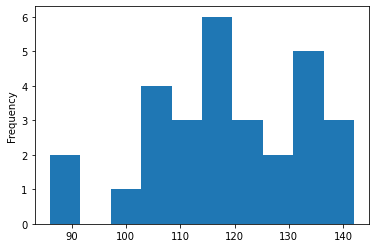

In [34]:
pdate4.pdate.plot.hist()

## Create campaign file for psims

In [43]:
#read data
latlon = pd.read_csv(r'C:/Users/uqjojeda/Nextcloud/PURTERRA-A0131/2020/inputs/LatLonByState.csv')
tile = pd.read_csv(r'C:/Users/uqjojeda/Nextcloud/PURTERRA-A0131/2020/inputs/Grids40KmList.csv')
camp = pd.read_csv(r'C:/Users/uqjojeda/Nextcloud/PURTERRA-A0131/2020/inputs/CampaignLatLonList.csv')

In [44]:
#work only with jday50, lat and lon, columns
psimspre = pd.merge(latlon, pdate4, how="outer", on="STATE_FIPS")
psims2 = psimspre.dropna()
final = pd.merge(camp, psims2, how="outer", on=["lat","lon"])
final2 = final.drop(['state', 'STATE_FIPS'],axis=1)
final2[['pdate']] = final2[['pdate']].fillna(axis=1, value=143)
final2[['pdate']] = final2[['pdate']].round(decimals=0)

In [37]:
final2.state_name.unique()

array([nan, 'TEXAS', 'NEBRASKA', 'OKLAHOMA', 'KANSAS', 'MINNESOTA',
       'IOWA', 'MISSOURI', 'ARKANSAS', 'LOUISIANA', 'WISCONSIN',
       'MISSISSIPPI', 'ILLINOIS', 'TENNESSEE', 'MICHIGAN', 'KENTUCKY',
       'ALABAMA', 'INDIANA', 'FLORIDA', 'GEORGIA', 'OHIO',
       'NORTH CAROLINA', 'VIRGINIA', 'SOUTH CAROLINA', 'PENNSYLVANIA',
       'NEW YORK', 'MARYLAND', 'DISTRICT OF COLUMBIA', 'DELAWARE',
       'NEW JERSEY'], dtype=object)

In [114]:
#final2.to_csv(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\inputs\ss.csv')

In [45]:
#Use pivot table to create the array for the campaign file in psims
final3 = final2.pivot_table(values='pdate',index='lat',columns='lon', dropna=False)
final3.to_csv(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\inputs\pdateCampaign.csv')